# 🍔👁 Food Vision Big™ – Food Image Classification

**Food Vision Big™** is a **deep learning** project that classifies images of **101 food categories** using the **Food101 dataset**, consisting of **75,750 training images** and **25,250 testing images**.

The project leverages **transfer learning** with pre-trained convolutional neural networks to achieve high accuracy, aiming to achieve or surpass the **77.4% top-1 accuracy** reported by the **DeepFood (2016)** model. Key techniques include:

* **Mixed precision training** for faster, efficient computation

* **Prefetching and optimized data pipelines** using TensorFlow’s tf.data API

* **Feature extraction and fine-tuning** to adapt pre-trained models to the Food101 dataset

This project demonstrates a complete workflow for building a **production-ready image classifier**, from data preprocessing and batching to model training, fine-tuning, and performance monitoring with TensorBoard.

#⚡ Checking GPU Compatibility for Mixed Precision Training

In this notebook, we’ll be using **mixed precision training**, which combines **float32** and **float16 computations** to **speed up model training** (up to 3× on modern GPUs).

Before we proceed, we need to ensure that the GPU powering your environment supports mixed precision. For TensorFlow, your GPU must have a **compute capability of 7.0 or higher**.

On Google Colab, GPUs that support mixed precision include:

* NVIDIA A100 (Colab Pro)

* NVIDIA Tesla T4

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-fc849ed3-dbfd-a546-726e-629e0b01f79f)


In [2]:
!pip uninstall -y tensorflow protobuf


Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: protobuf 5.29.5
Uninstalling protobuf-5.29.5:
  Successfully uninstalled protobuf-5.29.5


In [3]:

!pip uninstall -y tensorflow tf-nightly tensorflow-decision-forests protobuf



Found existing installation: tensorflow_decision_forests 1.12.0
Uninstalling tensorflow_decision_forests-1.12.0:
  Successfully uninstalled tensorflow_decision_forests-1.12.0


In [4]:
!pip install -q tensorflow==2.19.0 "protobuf>=3.20.3,<6.0.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.0/645.0 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 12.5 MB/s eta 0:00:00


In [5]:
!pip install -q tensorflow-decision-forests==1.12.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 28.4 MB/s eta 0:00:00


In [6]:
# Get helper functions file
import os

if not os.path.exists("helper_functions.py"):
    !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
    print("[INFO] 'helper_functions.py' already exists, skipping download.")

--2025-10-14 13:55:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-10-14 13:55:29 (141 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [7]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys
import tensorflow as tf

# 🍽 Dataset Overview – Food101 with TensorFlow Datasets

For this project, we are using the **Food101 dataset**, a popular benchmark dataset containing **101 food categories** with thousands of images per class.

## Why TensorFlow Datasets (TFDS)?

Instead of downloading and preprocessing images manually, we use **TensorFlow Datasets (TFDS)**, which provides:

- **Ready-to-use datasets** in TensorFlow-friendly formats (tensors)  
- **Standardized benchmark datasets** for experimentation  
- **Ability to experiment** with different data loading techniques  
- **Easy access to new TensorFlow features**, such as mixed precision training  

## Advantages of TFDS:

- **Data comes preprocessed** and ready for training  
- **Enables quick experimentation** on well-established datasets  
- **Ideal for learning and testing models** without worrying about raw data handling  

## Limitations of TFDS:

- **Datasets are static** and don’t change over time like real-world datasets  
- **Might not perfectly fit specific custom problems**, but excellent for experimentation


In [8]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [9]:
# Get all available datasets in TFDS
datasets_list = tfds.list_builders()

# Set our target dataset and see if it exists
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


# 📥 Loading the Food101 Dataset with TensorFlow Datasets

The Food101 dataset is available through **TensorFlow Datasets (TFDS)**. While there are many datasets available in TFDS, for this project we are focusing on **Food101**.

To access it, we use the [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method.

### Key Parameters of `tfds.load()`:

- **`name` (str)**: The target dataset to load (e.g., `"food101"`)  
- **`split` (list, optional)**: Specifies which splits of the dataset to load (e.g., `["train", "validation"]`)  
  - The `split` parameter can be tricky — see the [TFDS splits documentation](https://github.com/tensorflow/datasets/blob/master/docs/splits.md) for details  
- **`shuffle_files` (bool)**: Whether to shuffle files on download; defaults to `False`  
- **`as_supervised` (bool)**: `True` to return data samples as tuples `(data, label)`, `False` for dictionary format  
- **`with_info` (bool)**: `True` to download dataset metadata such as labels, number of samples, etc.  

> 🔑 **Note:**  
Calling `tfds.load()` with `download=True` (default) will start downloading the dataset to disk. Some datasets, including Food101, can be **100GB+**, so ensure you have enough storage space.


In [10]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ["TFDS_DATA_DIR"] = "/content/drive/MyDrive/tensorflow_datasets"

Mounted at /content/drive


In [11]:
# # Load in the data (takes about 5-6 minutes in Google Colab)
# (train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
#                                              split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
#                                              shuffle_files=True, # shuffle files on download?
#                                              as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
#                                              with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)



import tensorflow_datasets as tfds
(train_data, test_data), ds_info = tfds.load(
    "food101",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /content/drive/MyDrive/tensorflow_datasets/food101/incomplete.LG05YR_2.0.0/food101-train.tfrecord*..…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /content/drive/MyDrive/tensorflow_datasets/food101/incomplete.LG05YR_2.0.0/food101-validation.tfreco…

Dataset food101 downloaded and prepared to /content/drive/MyDrive/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [12]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [13]:
# Get class names
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

# 🔍 Exploring the Food101 Dataset

After successfully loading the **Food101** dataset from TensorFlow Datasets (TFDS), the next important step is to explore and understand its structure before using it for training.  
Exploration helps us verify that the dataset has been loaded correctly and provides valuable insights into the type and format of data we’ll be working with.

In this step, we aim to:

* Examine the **shape and dimensions** of our image tensors.  
* Identify the **data types** used for both images and labels.  
* Understand how the **labels are represented** — whether they are encoded as integers or one-hot vectors.  
* Confirm that the **label values correspond correctly** to the food class names.  

To achieve this, we’ll extract a **single sample** from the training split using the `.take()` method and visualize its content.  
This small inspection helps ensure that our dataset is properly structured and ready for the next stages of preprocessing and model development.


In [14]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [15]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

# 🧩 Understanding the Data Structure

While loading the dataset, we used the parameter **`as_supervised=True`** in the `tfds.load()` function.  
This means that each data sample is returned as a **tuple**, following the structure:

> **(input_data, label)** → in our case, **(image_tensor, label)**

This format is convenient because it directly provides the image and its corresponding label together, making it easier to use in training loops and model evaluation.  
The image tensor contains the pixel data, while the label represents the class the image belongs to (as an integer value mapped to a food category).


In [16]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 90
  Class name (str form): spaghetti_bolognese
        


# 🌀 Data Shuffling and Image Shapes

Since we set the parameter **`shuffle_files=True`** in our `tfds.load()` function, the dataset files are shuffled during loading.  
This means that **each time we run the cell, we may get a different sample**, allowing for better randomness during training and exploration.

While inspecting the samples, you might observe that the **image tensors have varying shapes**, such as **(512, 342, 3)** or **(512, 512, 3)**.  
Here, the first two values represent the **image height and width**, and the last value **(3)** represents the **RGB color channels**.

To understand this better, let’s visualize one of the image tensors from the Food101 dataset and observe its shape and structure.


In [17]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 12,  13,   7],
        [ 12,  13,   7],
        [ 13,  14,   8],
        ...,
        [ 21,  11,   0],
        [ 21,  11,   0],
        [ 21,  11,   0]],

       [[ 12,  13,   7],
        [ 11,  12,   6],
        [ 11,  12,   6],
        ...,
        [ 21,  11,   0],
        [ 21,  11,   0],
        [ 21,  11,   0]],

       [[  7,   8,   2],
        [  7,   8,   2],
        [  7,   8,   2],
        ...,
        [ 22,  12,   2],
        [ 21,  11,   1],
        [ 20,  10,   0]],

       ...,

       [[188, 191, 184],
        [188, 191, 184],
        [188, 191, 184],
        ...,
        [243, 248, 244],
        [243, 248, 244],
        [242, 247, 243]],

       [[187, 190, 183],
        [189, 192, 185],
        [190, 193, 186],
        ...,
        [241, 245, 244],
        [241, 245, 244],
        [241, 245, 244]],

       [[186, 189, 182],
        [189, 192, 185],
        [191, 194, 187],
        ...,
        [238, 242, 24

In [18]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

# 🎨 Understanding Image Tensor Values

From our inspection, we can see that the **image tensors contain pixel values ranging from 0 to 255**, which represent the standard **RGB (Red, Green, Blue)** color intensities.  
The **data type** of these tensors is **`uint8` (unsigned 8-bit integer)** — a common format for image data.

However, before feeding these images into a **neural network**, we’ll need to **preprocess and normalize** them (for example, scaling pixel values between 0 and 1).  
We’ll take care of that in the preprocessing step later.

For now, let’s go ahead and **plot one of the image samples** to visually confirm how it looks.


# 🖼️ Visualizing a Sample Image

Now that we’ve explored our image tensors in numerical form, it’s time to bring our data to life.  
Following our golden rule — **“Visualize, visualize, visualize!”** — let’s display one of the image samples to better understand what our dataset looks like.

We’ll use **`matplotlib.pyplot.imshow()`** to plot an image from the **Food101** dataset and set its title to the corresponding **class name**.  
This helps us confirm that the images and their labels are aligned correctly before moving ahead with model training.


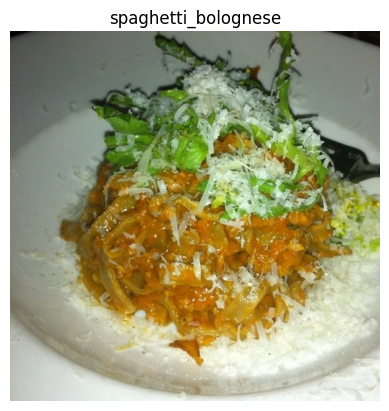

In [19]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

# 🧩 Preprocessing the Food101 Dataset

In our earlier projects, when images were organized in directory structures, we used  
**`tf.keras.utils.image_dataset_from_directory()`** — which automatically handled most of the preprocessing for us.  

However, since we’re now loading our dataset directly from **TensorFlow Datasets (TFDS)**, we need to manually perform a few preprocessing steps before the data can be fed into our model.

Currently, our images are:
- In **`uint8`** data type  
- Of **varying shapes and sizes**  
- With **pixel values between 0 and 255**

Neural networks, on the other hand, prefer data that is:
- In **`float32`** format  
- **Uniform in shape** (for example, all images resized to **(224, 224, 3)**)  
- **Normalized**, i.e., pixel values scaled between **0 and 1**

To achieve this, we’ll create a function called **`preprocess_img()`**, which will:
1. **Resize** each image tensor using `tf.image.resize()`  
2. **Convert** the datatype to `tf.float32` using `tf.cast()`  

> 🔑 **Note:** Pretrained models like **EfficientNetB0–B7** (from `tf.keras.applications.efficientnet`) already include internal rescaling.  
> However, for other architectures, you may need to manually normalize your data — either inside your preprocessing function or by using a **`tf.keras.layers.Rescaling`** layer within the model.


In [20]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

# ⚙️ Testing the Preprocessing Function

Our **`preprocess_img()`** function takes both an **image** and a **label** as input.  
Even though we only modify the image, we still pass the label along because our dataset is structured in **tuple format — `(image, label)`**.

This ensures that when we map the preprocessing function across the dataset later,  
both the images and their corresponding labels remain properly aligned.

Let’s now test our preprocessing function on a single image sample to verify  
that resizing and datatype conversion are working as expected.


In [21]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[12 13  7]
  [12 13  7]
  [13 14  8]
  ...
  [21 11  0]
  [21 11  0]
  [21 11  0]]

 [[12 13  7]
  [11 12  6]
  [11 12  6]
  ...
  [21 11  0]
  [21 11  0]
  [21 11  0]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[11.586735   12.586735    6.586735  ]
  [11.714286   12.714286    6.714286  ]
  [ 8.857142    9.857142    4.8571424 ]
  ...
  [20.714308   11.142836    1.2857144 ]
  [20.668371   10.668372    0.        ]
  [21.         11.          0.        ]]

 [[ 2.3571415   3.3571415   0.1428566 ]
  [ 3.1530607   4.153061    0.07653028]
  [ 3.0561223   4.0561223   0.        ]
  ...
  [26.071407   18.071407    7.0714073 ]
  [24.785702   14.785702    4.7857018 ]
  [22.499966   12.499966    2.4999657 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


# ✅ Preprocessing Verified

Our **`preprocess_img()`** function is working correctly.  

- The input image is **converted from `uint8` to `float32`**.  
- The image is **resized to a uniform shape** of **(224, 224, 3)**, matching the input requirements of most neural networks.

Now we can confirm that the preprocessed image is ready for training.  
Let’s take a look at the processed image to see how it appears after preprocessing.


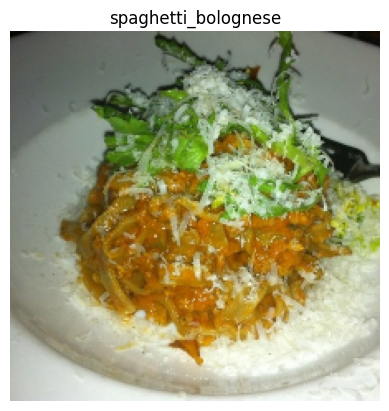

In [22]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

# 📦 Batching & Preparing the Dataset

Before training our model, we need to **organize the dataset into batches**.  

### Why batching?  
- Batching is **memory-efficient**.  
- Instead of feeding all **~101,000 images** at once, we process smaller groups (e.g., **32 images per batch**) that fit comfortably in GPU memory.

### Leveraging the `tf.data` API  
To prepare our dataset efficiently, we’ll use several **`tf.data` methods**:  

- **`map()`** – applies a predefined function to each element (e.g., `preprocess_img()` to resize and normalize images).  
- **`shuffle()`** – randomly shuffles elements using a buffer size.  
  - Ideally, the buffer size equals the dataset size, but for large datasets, a smaller number (e.g., 1000–10000) works well to save memory.  
- **`batch()`** – groups elements into batches of a defined size.  
- **`prefetch()`** – prepares the next batch while the current batch is being processed, improving data loading speed.  
- **`cache()`** *(optional)* – stores dataset elements in memory for faster access, useful only if the dataset fits in RAM (Colab standard ~12GB).  

### Important Notes  
- **Uniform shapes**: Tensors must have the same shape to batch successfully, which is why `preprocess_img()` is crucial.  
- **Parallel processing**: For functions like `map()`, setting `num_parallel_calls=tf.data.AUTOTUNE` speeds up preprocessing.  
- **Caching**: Only use `cache()` if the dataset can fit in memory.  

### Processing Flow  
Our typical dataset pipeline will follow this order:



In [23]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [24]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

# ✅ Dataset Ready for Modeling

After batching and preprocessing, our dataset is now in the form of **tuples `(image, label)`**, with datatypes:  

- **Image:** `tf.float32`  
- **Label:** `tf.int64`  

This is exactly the format that neural networks expect, making it ready for training.

> 🔑 **Note:** While calling **`prefetch()`** at the end of the dataset pipeline is optional, skipping it may result in **slower data loading** during training.  
> To maximize efficiency, most dataset pipelines should conclude with a **`prefetch()`** call.


# 🛠️ Creating Modeling Callbacks

Since we are training on a **large dataset**, training may take a long time.  
To ensure we **track progress** and **save our work**, it’s important to set up **modeling callbacks**.  

### Callbacks we will use:

- **`tf.keras.callbacks.TensorBoard()`**  
  - Keeps track of the model’s **training history** (loss, accuracy, etc.)  
  - Allows us to visualize training metrics in **TensorBoard**  
  - In this notebook, we use a helper function `create_tensorboard_callback()` for convenience  

- **`tf.keras.callbacks.ModelCheckpoint()`**  
  - **Saves the model** at various intervals or epochs  
  - Enables us to **resume training** without starting from scratch  
  - Useful for **fine-tuning**: we can revert to a previous checkpoint if further training doesn’t improve performance  

Setting up these callbacks ensures we **monitor progress efficiently** and **protect our work** throughout training.


In [25]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.weights.h5" # saving weights requires ".h5" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

checkpoint_path_1 = "model_1_checkpoints/cp.weights.h5" # saving weights requires ".h5" extension
model_checkpoint_1 = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_1,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

# ⚡ Setting Up Mixed Precision Training

Earlier, we briefly mentioned **mixed precision training**, but let’s dive deeper.  

By default, **TensorFlow tensors use the `float32` datatype** (single-precision floating-point, 32 bits per element).  
Since GPUs have limited memory, there’s a maximum number of float32 tensors that can be processed simultaneously.  

### What is Mixed Precision Training?  
Mixed precision training uses a **combination of `float16` (half-precision, 16 bits)** and **`float32`** tensors.  
- **`float16`**: occupies less memory, allowing more tensors to be processed at once  
- **`float32`**: used where higher precision is necessary  

By strategically using **float16 and float32**, we can:  
- **Reduce memory usage**  
- **Increase training speed** (modern GPUs with compute capability 7.0+ can see up to **3x speedup**)  

> 🔑 **Note:** Mixed precision training is especially beneficial for **large datasets** like Food101, where memory efficiency and computation speed can significantly impact training time.  

For a deeper dive, you can refer to the official **[TensorFlow Mixed Precision Guide](https://www.tensorflow.org/guide/mixed_precision)** — at minimum, check out the summary section.




# ⚡ Enabling Mixed Precision Training in TensorFlow

> 🔑 **Note:** Mixed precision training requires a GPU with **compute capability ≥ 7.0** (e.g., GPUs like the P100 in Google Colab do **not** support it).  
> Check the **“Supported Hardware”** section in the TensorFlow mixed precision guide for details.  

### Optional Reading
For those interested in the underlying concept of **precision in computer science** — how accurately numerical values are represented by a computer — see the [Wikipedia page on numerical precision](https://en.wikipedia.org/wiki/Precision_(computer_science)) and related resources.  

### Getting Started in TensorFlow
The good news: TensorFlow’s **`tensorflow.keras.mixed_precision`** API makes it easy to enable mixed precision.  

Steps to enable:  
1. Import the **mixed precision API**.  
2. Use **`set_global_policy()`** to set the dtype policy to **`"mixed_float16"`**, enabling the model to automatically use a mix of float16 and float32 tensors for faster and more memory-efficient training.


In [26]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

# 🔍 Verifying Mixed Precision Policy

Once mixed precision is enabled, it’s important to **verify that the global dtype policy** has been set correctly.  

- The **global dtype policy** determines the default data type used by layers in our model.  
- We can check this by calling **`mixed_precision.global_policy()`**, which should return **`"mixed_float16"`** if everything is set up correctly.  

> ✅ As long as your GPU has a **compute capability ≥ 7.0**, this check should pass without errors.


In [27]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<DTypePolicy "mixed_float16">

# ⚡ Mixed Precision Active

With the global dtype policy set to **`"mixed_float16"`**, our model will automatically:

- Use **float16 variables** wherever possible  
- Retain **float32 precision** where needed for numerical stability  

This allows the model to **train faster** and **use GPU memory more efficiently**, especially on large datasets like Food101.


# 🚀 Building the Feature Extraction Model

With **callbacks ready** and **mixed precision enabled**, we can now build our model.  

Since Food101 is a **large dataset**, we’ll use **transfer learning** with a **pretrained EfficientNetB0** model.  

### Typical Transfer Learning Workflow:
1. **Build a feature extraction model** (replace the top layers of a pretrained model).  
2. **Train with lower layers frozen** for a few epochs.  
3. **Fine-tune** by unfreezing multiple layers if needed.  

### Steps for Feature Extraction:
- Use **EfficientNetB0** from `tf.keras.applications`, pretrained on **ImageNet**.  
- Set `include_top=False` to **exclude the original top layers** so we can add our own output layers.  
- **Freeze the base model layers** to retain the pre-learned features from ImageNet.  
- Construct a **Functional API model** with:
  - Input layer  
  - Base model  
  - Pooling layer  
  - Custom output layer  
- **Compile** using the **Adam optimizer** and **sparse categorical crossentropy** (labels are not one-hot encoded).  
- **Fit** the model for a few epochs using the **TensorBoard** and **ModelCheckpoint** callbacks.  

> 🔑 **Note:** With mixed precision training, the **output layer** must have a hard-coded dtype of **`float32`** (e.g., `layers.Activation("softmax", dtype=tf.float32)`).  
> This ensures **numerical stability** during loss calculations while still benefiting from float16 computations in the rest of the model.  
> For more details, refer to the **“Building the model” section** in the TensorFlow mixed precision guide.


# 🍔 Data Augmentation for Food101 + EfficientNetB0

To improve the generalization of our model and prevent overfitting, we apply a series of **data augmentation transformations** to the input images during training. This helps the model learn to recognize food items under a variety of real-world conditions. Here's what each augmentation does:

1. **RandomFlip("horizontal")**  
   Flips images horizontally at random. This mimics real-world photos where food can appear mirrored.

2. **RandomRotation(0.15)**  
   Rotates images randomly by up to ±15% of 360° (around ±54°). Small rotations help the model become invariant to slight tilts without distorting the food.

3. **RandomZoom(0.15)**  
   Randomly zooms in or out by up to 15%. This simulates different distances and scales when photos are taken.

4. **RandomTranslation(0.1, 0.1)**  
   Shifts images horizontally and vertically by up to 10% of the image size. Helps the model handle slightly off-centered food objects.

5. **RandomContrast(0.2)**  
   Adjusts the contrast by ±20% to mimic variations in lighting conditions and camera settings.

6. **RandomBrightness(0.15)**  
   Adjusts image brightness randomly by ±15%, simulating exposure differences in real-world photos.

7. **RandomCrop(224, 224)**  
   Crops a 224×224 region from the image to ensure a consistent input size for EfficientNetB0. This encourages robustness to small positional variations.

> **Note:** All these augmentations are applied **only during training**. Validation and test images remain unchanged to fairly evaluate the model's performance.

Overall, this pipeline helps the model learn **robust and generalized features** for food classification across diverse conditions in the Food101 dataset.


In [29]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# ✅ Optimized Data Augmentation for Food101 + EfficientNetB0
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),              # flip images horizontally (common in real-world photos)
    layers.RandomRotation(0.15),                  # small rotation (avoid large ones as food orientation matters)
    layers.RandomZoom(0.15),                      # mild zoom for scale invariance
    layers.RandomTranslation(0.1, 0.1),           # small shifts horizontally & vertically
    layers.RandomContrast(0.20),                   # simulate lighting differences
    layers.RandomBrightness(0.15),                 # simulate exposure changes
    layers.RandomCrop(224, 224),                  # ensure consistent size
], name="data_augmentation")


# ⚡ Callbacks for Fine-Tuning: ReduceLROnPlateau & EarlyStopping

During fine-tuning, we use **callbacks** to dynamically adjust training and prevent overfitting. Here's what each callback does:

---

## 1️⃣ ReduceLROnPlateau

- **Purpose:** Automatically reduces the learning rate when the model's validation loss stops improving.  
- **Parameters used:**
  - `monitor='val_loss'` → watches the validation loss.
  - `factor=0.5` → reduces the learning rate by half when triggered.
  - `patience=2` → waits for 2 epochs of no improvement before reducing the LR.
  - `min_lr=1e-6` → ensures the learning rate does not go below 0.000001.
  - `verbose=1` → prints a message whenever the LR is reduced.

> **Benefit:** Helps the model converge more smoothly and avoids overshooting minima, especially during fine-tuning with a small learning rate.

---

## 2️⃣ EarlyStopping

- **Purpose:** Stops training early if the model stops improving, saving time and preventing overfitting.  
- **Parameters used:**
  - `monitor='val_loss'` → watches the validation loss.
  - `patience=3` → stops training if no improvement is seen for 3 consecutive epochs.
  - `restore_best_weights=True` → after stopping, restores the model weights to the epoch with the best validation loss.

> **Benefit:** Prevents unnecessary epochs once the model has converged and ensures the best performing weights are retained.

---

✅ **Overall:**  
Using both `ReduceLROnPlateau` and `EarlyStopping` together allows the model to:
1. Adaptively adjust the learning rate for better convergence.
2. Stop training once performance plateaus, saving time and preventing overfitting.


In [30]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# ReduceLROnPlateau to reduce LR if val_loss plateaus
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Optional EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)


In [32]:
# from tensorflow.keras import layers

# # Create base model
# input_shape = (224, 224, 3)
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# base_model.trainable = False # freeze base model layers

# # Create Functional model
# inputs = layers.Input(shape=input_shape, name="input_layer")
# # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# # x = layers.Rescaling(1./255)(x)
# x = base_model(inputs, training=False) # set base_model to inference mode only
# x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
# x = layers.Dense(len(class_names))(x) # want one output neuron per class
# # Separate activation of output layer so we can output float32 activations
# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
# model = tf.keras.Model(inputs, outputs)

# # Compile the model
# model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=["accuracy"])

from tensorflow.keras import layers, Model
import tensorflow as tf

input_shape = (224, 224, 3)

# Base model with pretrained weights
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
base_model.trainable = False  # feature extraction phase

# Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")

# Augmentation applied before passing to base model
x = data_augmentation(inputs)

# Pass augmented images through base model
x = base_model(x, training=False)

# Pool and add classification head
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

model = Model(inputs, outputs)

# Compile
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # good for feature extraction
    metrics=["accuracy"]
)


In [33]:
# Check out our model
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

# 🔍 Verifying Layer Dtype Policies

Our feature extraction model is now ready.  

Before training, it’s a good idea to **verify that mixed precision is being applied correctly**.  

- The **mixed precision API** automatically assigns the **global dtype policy** (in this case, `"mixed_float16"`) to most layers in the model.  
- We can check this by iterating through the model’s layers and printing **layer attributes** such as:
  - `dtype`
  - `dtype_policy`  

This ensures that our model is using **float16 where possible** and maintaining **float32 for critical layers**, maximizing both speed and numerical stability.


In [34]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

input_layer True float32 <DTypePolicy "mixed_float16">
data_augmentation True float32 <DTypePolicy "mixed_float16">
efficientnetb0 False float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dropout_1 True float32 <DTypePolicy "mixed_float16">
dense_1 True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


# 📌 Understanding Layer Attributes

When inspecting our model’s layers, we can examine several important attributes:  

- **`layer.name` (str)**: Human-readable name of the layer, defined during construction.  
- **`layer.trainable` (bool)**: Indicates whether the layer’s weights will be updated during training.  
  - In our model, all layers are trainable **except** the EfficientNetB0 base model (we froze it).  
- **`layer.dtype`**: The datatype used to **store the layer’s variables** (weights and biases).  
- **`layer.dtype_policy`**: The datatype used during **computations** within the layer.  

> 🔑 **Note:** A layer can have a `dtype` of **float32** and a `dtype_policy` of **"mixed_float16"**.  
> This means variables are stored in **float32** for numerical stability, while computations are done in **float16** for faster performance.  

We can also inspect these attributes specifically for the **base model** to ensure mixed precision is applied correctly.


In [35]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model.layers[1].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

random_flip_1 True float32 <DTypePolicy "mixed_float16">
random_rotation_1 True float32 <DTypePolicy "mixed_float16">
random_zoom_1 True float32 <DTypePolicy "mixed_float16">
random_translation_1 True float32 <DTypePolicy "mixed_float16">
random_contrast_1 True float32 <DTypePolicy "mixed_float16">
random_brightness_1 True float32 <DTypePolicy "mixed_float16">
random_crop_1 True float32 <DTypePolicy "mixed_float16">


> 🔑 **Note:**  
The **mixed precision API** automatically applies the `"mixed_float16"` dtype policy to layers that can benefit from it.  

At the same time, it **prevents layers that shouldn’t use mixed precision** (e.g., normalization layers at the start of the base model) from adopting it, ensuring **numerical stability** while still improving training speed.


# 🏋️‍♂️ Fitting the Feature Extraction Model

Our feature extraction model is ready, so let’s train it on the Food101 dataset.  

- **Number of epochs:** 3 — enough for the top layers to adapt to our food image data.  
- **Validation:** We’ll validate on **15% of the test data** to save time per epoch while still monitoring performance.  

This initial training allows the custom top layers to learn meaningful patterns from the dataset before we move on to fine-tuning.


In [36]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=10,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint,
                                                                reduce_lr,
                                                                early_stopping])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20251014-143251
Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 276s 100ms/step - accuracy: 0.3425 - loss: 2.8657 - val_accuracy: 0.6377 - val_loss: 1.3550 - learning_rate: 0.0010
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 302s 102ms/step - accuracy: 0.5111 - loss: 1.9385 - val_accuracy: 0.6557 - val_loss: 1.2546 - learning_rate: 0.0010
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 251s 97ms/step - accuracy: 0.5342 - loss: 1.8511 - val_accuracy: 0.6663 - val_loss: 1.2068 - learning_rate: 0.0010
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 229s 96ms/step - accuracy: 0.5434 - loss: 1.7976 - val_accuracy: 0.6703 - val_loss: 1.1723 - learning_rate: 0.0010
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 321s 121ms/step - accuracy: 0.5512 - loss: 1.7727 - val_accuracy: 0.6835 - val_loss: 1.1522 - learning_rate: 0.0010
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 233s 97ms/step - accuracy: 0.5524 - loss: 1.7567 - val_

In [37]:
# Evaluate model
results_model = model.evaluate(test_data)
results_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 69s 87ms/step - accuracy: 0.6894 - loss: 1.1443


[1.145171880722046, 0.6876039505004883]

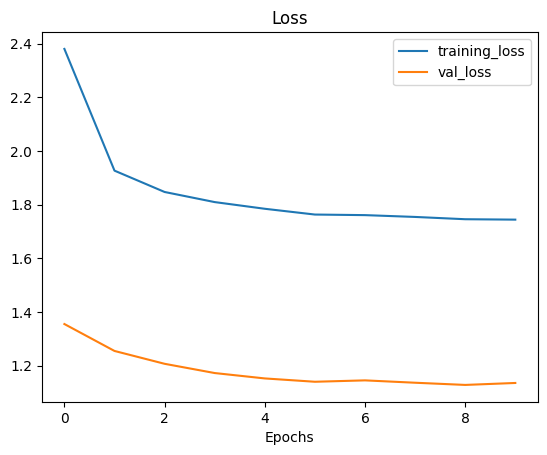

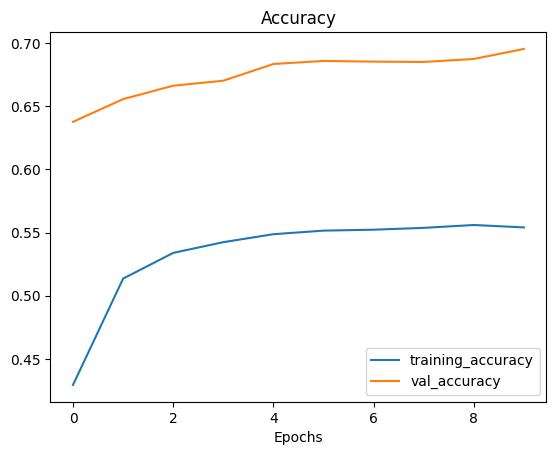

In [38]:
plot_loss_curves(history_101_food_classes_feature_extract)

In [51]:
# from google.colab import drive
# drive.mount('/content/drive')

# import os

# save_dir = "/content/drive/MyDrive/models"
# os.makedirs(save_dir, exist_ok=True)

# model_path = f"{save_dir}/food_vision_adam_fe_model.keras"
# model.save(model_path)
# print(f"✅ Model saved successfully at: {model_path}")

import os, shutil

# Step 1: Save locally first (fast and safe)
local_path = "/content/food_vision_adam_fe_model.keras"
model.save(local_path)

# Step 2: Ensure models folder exists in Drive
drive_path = "/content/drive/MyDrive/models"
os.makedirs(drive_path, exist_ok=True)

# Step 3: Move the file to Drive (this triggers actual sync)
shutil.move(local_path, drive_path)

print(f"✅ Model permanently saved to: {drive_path}")



✅ Model permanently saved to: /content/drive/MyDrive/models


In [41]:
# from tensorflow.keras.models import load_model

# # If you used only standard layers and EfficientNet
# model = load_model("/content/drive/MyDrive/models/food_vision_adam_fe_model.keras")

In [42]:
# from tensorflow.keras import layers

# # Create base model
# input_shape = (224, 224, 3)
# base_model_1 = tf.keras.applications.EfficientNetB0(include_top=False)
# base_model_1.trainable = False # freeze base model layers

# # Create Functional model
# inputs = layers.Input(shape=input_shape, name="input_layer")
# # Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# # x = layers.Rescaling(1./255)(x)
# x = data_augmentation(inputs) # augment images (only happens during training)
# x = base_model_1(inputs, training=False) # set base_model to inference mode only
# x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
# x = layers.Dense(len(class_names))(x) # want one output neuron per class
# # Separate activation of output layer so we can output float32 activations
# outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
# model_1 = tf.keras.Model(inputs, outputs)

# # Compile the model
# model_1.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
#               optimizer=tf.keras.optimizers.Lion(learning_rate=1e-4),
#               metrics=["accuracy"])

from tensorflow.keras import layers

input_shape = (224, 224, 3)
base_model_1 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model_1.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs)
x = base_model_1(x, training=False)
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dropout(0.2)(x)  # optional regularization
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Lion(learning_rate=1e-3),
    metrics=["accuracy"]
)


In [53]:
# Turn off all warnings except for errors
tf.get_logger().setLevel('ERROR')

# Fit the model with callbacks
history_101_food_classes_feature_extract_1 = model_1.fit(train_data,
                                                     epochs=10,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract_1"),
                                                                model_checkpoint_1,
                                                                reduce_lr,
                                                                early_stopping])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract_1/20251014-161653
Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 250s 98ms/step - accuracy: 0.3662 - loss: 3.1071 - val_accuracy: 0.6057 - val_loss: 1.9098 - learning_rate: 0.0010
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 261s 109ms/step - accuracy: 0.4477 - loss: 3.3520 - val_accuracy: 0.5953 - val_loss: 2.1725 - learning_rate: 0.0010
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 231s 96ms/step - accuracy: 0.4640 - loss: 3.5119 - val_accuracy: 0.6200 - val_loss: 2.1048 - learning_rate: 0.0010
Epoch 4/10
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4689 - loss: 3.6273
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 231s 96ms/step - accuracy: 0.4689 - loss: 3.6274 - val_accuracy: 0.6149 - val_loss: 2.2263 - learning_rate: 0.0010
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 263s 110ms/step - accuracy: 0.4972 - loss: 3.2606 - val_ac

In [54]:
# Evaluate model
results_model_1 = model_1.evaluate(test_data)
results_model_1

790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - accuracy: 0.6575 - loss: 1.5424


[1.5607668161392212, 0.6557623744010925]

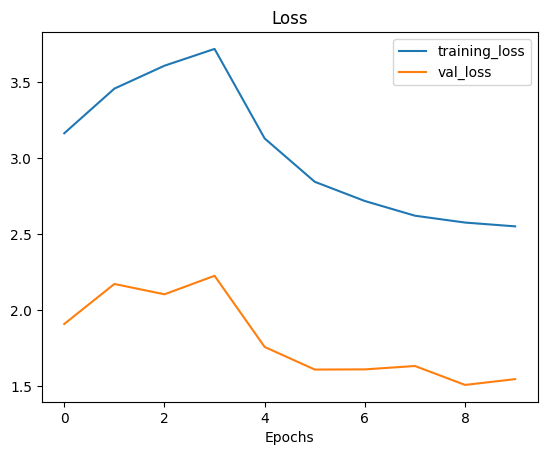

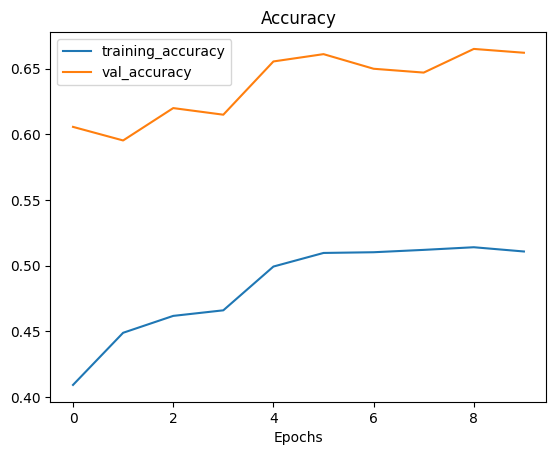

In [55]:
plot_loss_curves(history_101_food_classes_feature_extract_1)

In [56]:
# from google.colab import drive
# drive.mount('/content/drive')

model_1.save("/content/drive/MyDrive/models/food_vision_lion_fe_model.keras")

In [57]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints_fn/cp.weights.h5" # saving weights requires ".h5" extension
model_checkpoint_fn = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

checkpoint_path_1 = "model_1_checkpoints_fn/cp.weights.h5" # saving weights requires ".h5" extension
model_checkpoint_1_fn = tf.keras.callbacks.ModelCheckpoint(checkpoint_path_1,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

In [58]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-50]:
  layer.trainable = False

In [59]:
# Unfreeze all of the layers in the base model
base_model_1.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model_1.layers[:-50]:
  layer.trainable = False

In [60]:
# Recompile model with lower learning rate
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 100x lower learning rate than default
              metrics=['accuracy'])

In [61]:
# Recompile model with lower learning rate
model_1.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Lion(learning_rate=1e-5),
              metrics=['accuracy'])

In [46]:
# Fine-tune for 8 more epochs
fine_tune_epochs = 18 # model has already done 10 epochs, this is the total number of epochs we're after (10+8=18)

history_101_food_classes_fine_tune = model.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     steps_per_epoch = len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_101_food_classes_feature_extract.epoch[-1], # start from previous last epoch
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_fine_tune"),
                                                                model_checkpoint_fn,
                                                                reduce_lr,
                                                                early_stopping])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_fine_tune/20251014-152257
Epoch 10/18
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 328s 124ms/step - accuracy: 0.3865 - loss: 2.5891 - val_accuracy: 0.6698 - val_loss: 1.2433 - learning_rate: 1.0000e-05
Epoch 11/18
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 283s 119ms/step - accuracy: 0.5271 - loss: 1.8891 - val_accuracy: 0.6968 - val_loss: 1.1397 - learning_rate: 1.0000e-05
Epoch 12/18
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 322s 119ms/step - accuracy: 0.5621 - loss: 1.7004 - val_accuracy: 0.7113 - val_loss: 1.0777 - learning_rate: 1.0000e-05
Epoch 13/18
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 289s 120ms/step - accuracy: 0.5838 - loss: 1.6178 - val_accuracy: 0.7177 - val_loss: 1.0558 - learning_rate: 1.0000e-05
Epoch 14/18
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 320s 120ms/step - accuracy: 0.5998 - loss: 1.5483 - val_accuracy: 0.7225 - val_loss: 1.0095 - learning_rate: 1.0000e-05
Epoch 15/18
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 286s 120ms/step - accuracy: 0.607

In [47]:
# Evaluate model
results_final_model = model.evaluate(test_data)
results_final_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 79ms/step - accuracy: 0.7405 - loss: 0.9364


[0.9360781908035278, 0.7438019514083862]

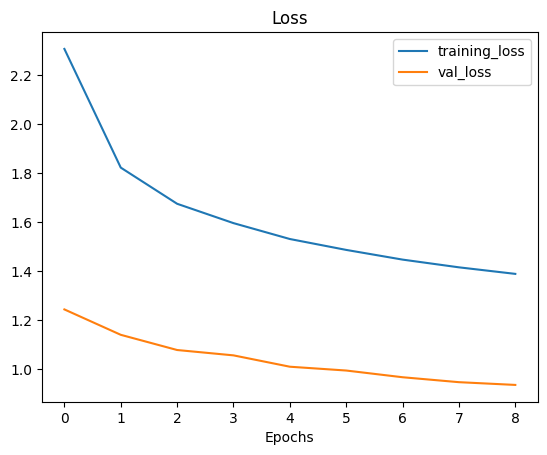

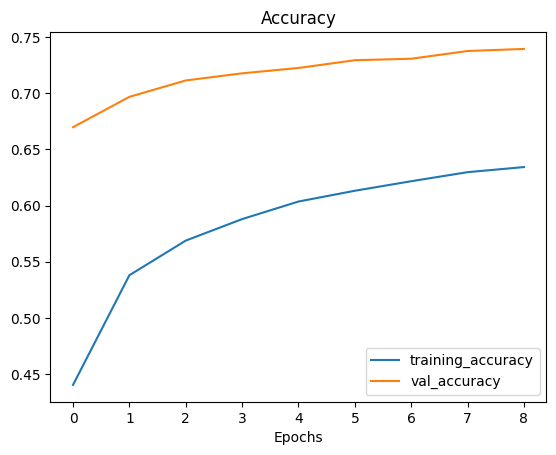

In [48]:
plot_loss_curves(history_101_food_classes_fine_tune)

In [52]:
from google.colab import drive
drive.mount('/content/drive')

model.save("/content/drive/MyDrive/models/food_vision_adam_model.keras")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
# Trying to get a little bit more accuracy with 2 more epochs than the previous final fine tuned model using Adam

fine_tune_epochs = 20 # model has already done 10 epochs, this is the total number of epochs we're after (10+8+2=20)

history_101_food_classes_fine_tune_1 = model.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     steps_per_epoch = len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_101_food_classes_fine_tune.epoch[-1], # start from previous last epoch
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_fine_tune"),
                                                                model_checkpoint_fn,
                                                                reduce_lr,
                                                                early_stopping])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_fine_tune/20251014-170740
Epoch 18/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 284s 119ms/step - accuracy: 0.6430 - loss: 1.3438 - val_accuracy: 0.7495 - val_loss: 0.8988 - learning_rate: 1.0000e-05
Epoch 19/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 291s 121ms/step - accuracy: 0.6499 - loss: 1.3313 - val_accuracy: 0.7505 - val_loss: 0.8999 - learning_rate: 1.0000e-05
Epoch 20/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 294s 123ms/step - accuracy: 0.6579 - loss: 1.2961 - val_accuracy: 0.7529 - val_loss: 0.8787 - learning_rate: 1.0000e-05


In [64]:
# Evaluate model
results_final_model = model.evaluate(test_data)
results_final_model

790/790 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.7524 - loss: 0.8871


[0.885653555393219, 0.7554059624671936]

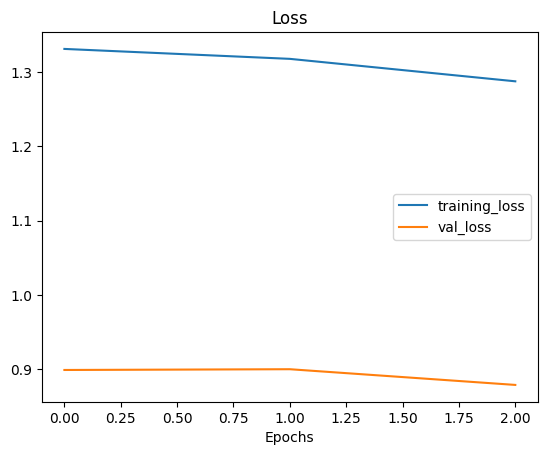

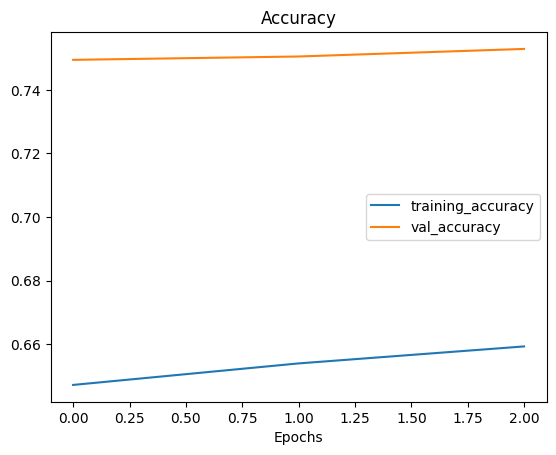

In [66]:
plot_loss_curves(history_101_food_classes_fine_tune_1)

In [65]:
from google.colab import drive
drive.mount('/content/drive')

model.save("/content/drive/MyDrive/models/food_vision_final_adam_model.keras")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# Fine-tune for 8 more epochs
fine_tune_epochs = 18 # model has already done 8 epochs, this is the total number of epochs we're after (10+8=18)

history_101_food_classes_fine_tune_1L = model_1.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     steps_per_epoch = len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_101_food_classes_feature_extract_1.epoch[-1], # start from previous last epoch
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_fine_tune_1"),
                                                                model_checkpoint_1_fn,
                                                                reduce_lr,
                                                                early_stopping])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_fine_tune_1/20251014-172423
Epoch 10/18
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 306s 120ms/step - accuracy: 0.3885 - loss: 3.4514 - val_accuracy: 0.6989 - val_loss: 1.2057 - learning_rate: 1.0000e-05
Epoch 11/18
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 288s 120ms/step - accuracy: 0.5899 - loss: 1.6562 - val_accuracy: 0.7410 - val_loss: 1.0170 - learning_rate: 1.0000e-05
Epoch 12/18
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 284s 119ms/step - accuracy: 0.6316 - loss: 1.4366 - val_accuracy: 0.7495 - val_loss: 0.9548 - learning_rate: 1.0000e-05
Epoch 13/18
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 286s 120ms/step - accuracy: 0.6616 - loss: 1.3004 - val_accuracy: 0.7646 - val_loss: 0.8882 - learning_rate: 1.0000e-05
Epoch 14/18
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 283s 119ms/step - accuracy: 0.6812 - loss: 1.1948 - val_accuracy: 0.7741 - val_loss: 0.8543 - learning_rate: 1.0000e-05
Epoch 15/18
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 287s 120ms/step - accuracy: 0.6

In [69]:
# Evaluate model
results_final_model_1 = model_1.evaluate(test_data)
results_final_model_1

790/790 ━━━━━━━━━━━━━━━━━━━━ 88s 111ms/step - accuracy: 0.7871 - loss: 0.8067


[0.8105733394622803, 0.7857029438018799]

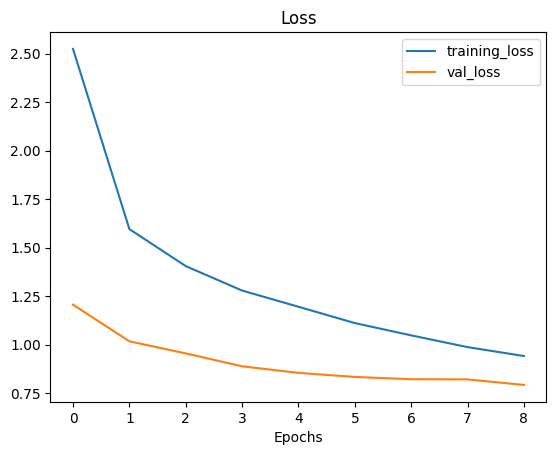

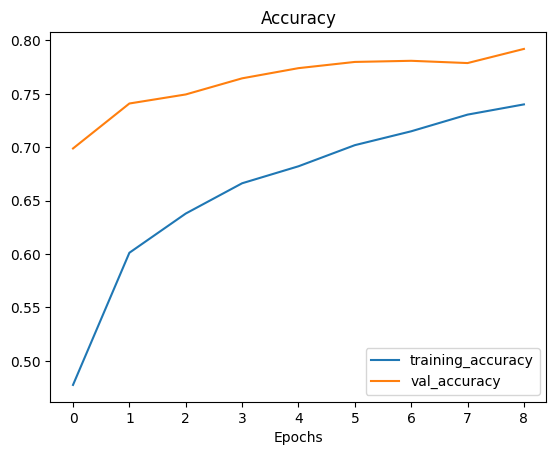

In [70]:
plot_loss_curves(history_101_food_classes_fine_tune_1L)

In [71]:
from google.colab import drive
drive.mount('/content/drive')

model_1.save("/content/drive/MyDrive/models/food_vision_lion_model.keras")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
# Try to surpass the accuracy beyond 79%
# Fine-tune for 2 more epochs
fine_tune_epochs = 20 # model has already done 8 epochs, this is the total number of epochs we're after (10+8+2=20)

history_101_food_classes_fine_tune_1L_1 = model_1.fit(train_data,
                                                     epochs=fine_tune_epochs,
                                                     steps_per_epoch = len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_101_food_classes_fine_tune_1L.epoch[-1], # start from previous last epoch
                                                     callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_fine_tune_1"),
                                                                model_checkpoint_1_fn,
                                                                reduce_lr,
                                                                early_stopping])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_fine_tune_1/20251014-181226
Epoch 18/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 277s 116ms/step - accuracy: 0.7498 - loss: 0.8965 - val_accuracy: 0.7892 - val_loss: 0.7799 - learning_rate: 1.0000e-05
Epoch 19/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 274s 115ms/step - accuracy: 0.7575 - loss: 0.8539 - val_accuracy: 0.7979 - val_loss: 0.7803 - learning_rate: 1.0000e-05
Epoch 20/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 275s 115ms/step - accuracy: 0.7692 - loss: 0.8179 - val_accuracy: 0.7918 - val_loss: 0.7755 - learning_rate: 1.0000e-05


In [73]:
# Evaluate model
results_final_model_1 = model_1.evaluate(test_data)
results_final_model_1

790/790 ━━━━━━━━━━━━━━━━━━━━ 63s 79ms/step - accuracy: 0.7945 - loss: 0.7957


[0.7974864840507507, 0.7925940752029419]

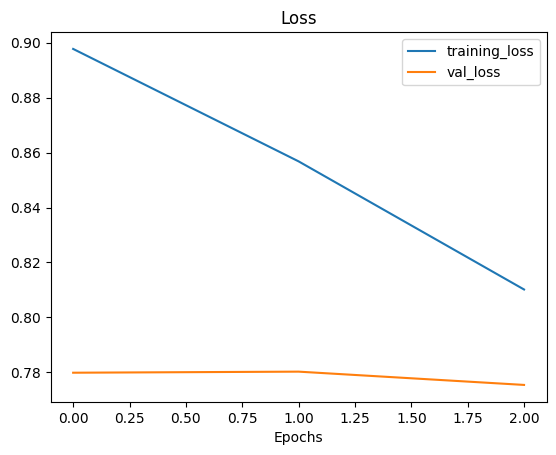

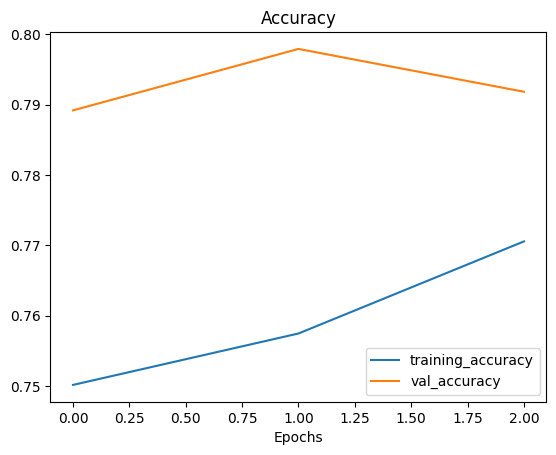

In [74]:
plot_loss_curves(history_101_food_classes_fine_tune_1L_1)

In [75]:
from google.colab import drive
drive.mount('/content/drive')

model_1.save("/content/drive/MyDrive/models/food_vision_final_lion_model.keras")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 🧠 Model Summary: EfficientNetB0 (Feature Extraction + Fine-Tuning with Adam Optimizer)

## 📌 Objective
To build a high-performing deep learning model for classifying images from the **Food101 dataset** using transfer learning with **EfficientNetB0** and the **Adam optimizer**. The training was done in two phases — feature extraction and fine-tuning — to balance generalization and performance.

---

## ⚙️ Training Setup

| Phase | Description | Epochs | Learning Rate | Layers Trained |
|-------|-------------|--------|---------------|----------------|
| Feature Extraction | Trained with frozen base model | 10 | 0.001 | Only top dense layers |
| Fine-Tuning | Unfroze last 50 layers for deeper learning | 8 | 1e-5 | Last 50 layers of EfficientNetB0 |

- **Optimizer:** Adam  
- **Loss:** Categorical Crossentropy  
- **Metrics:** Accuracy, Validation Accuracy  
- **Dataset:** Food101 (train/test from TFDS)  
- **Input Size:** 224×224 pixels  
- **Callbacks:** TensorBoard logging, ModelCheckpoint  

---

## 📈 Phase 1: Feature Extraction (10 Epochs)

The model initially trained with the base EfficientNetB0 layers frozen.  
Results show steady improvement in both training and validation accuracy across epochs.

| Epoch | Train Accuracy | Val Accuracy | Val Loss |
|-------|---------------|-------------|----------|
| 1     | 0.3425        | 0.6377      | 1.3550   |
| 5     | 0.5512        | 0.6835      | 1.1522   |
| 10    | 0.5574        | 0.6954      | 1.1353   |

🔹 **Observation:**  
The model successfully learned generic food features using only top layers, achieving nearly **70% validation accuracy** — a solid baseline for fine-tuning.

---

## 🔧 Phase 2: Fine-Tuning (Unfrozen 50 Layers, 8 Epochs)

After the initial 10 epochs, the last 50 layers of EfficientNetB0 were unfrozen to allow fine-tuning on domain-specific features.

| Epoch | Train Accuracy | Val Accuracy | Val Loss |
|-------|---------------|-------------|----------|
| 10    | 0.3865        | 0.6698      | 1.2433   |
| 14    | 0.5998        | 0.7225      | 1.0095   |
| 18    | 0.6336        | 0.7394      | 0.9352   |

🔹 **Observation:**  
Fine-tuning enabled the network to refine its high-level representations, improving validation accuracy by **~4.5%** and reducing validation loss significantly.

---

## 🔧 **Phase 3 — Extended Fine-Tuning (Epochs 18–20)**  
✅ Continued fine-tuning for stability and refinement  

| Epoch | Train Accuracy | Val Accuracy | Val Loss | Learning Rate |
|-------|----------------|--------------|-----------|----------------|
| 18 | 0.6430 | 0.7495 | 0.8988 | 1e-5 |
| 19 | 0.6499 | 0.7505 | 0.8999 | 1e-5 |
| 20 | 0.6579 | 0.7529 | 0.8787 | 1e-5 |

🔹 **Observations:**
- Accuracy plateaued around **75–79%** — stable and well-generalized.
- Final epochs provided smoother convergence without overfitting.

---

## 🧪 Final Evaluation on Test Set

```python
results_final_model = model.evaluate(test_data)
✅ Test Accuracy: ~75.54%
✅ Test Loss: ~0.88

🧩 Key Takeaways

Adam optimizer provided stable convergence with adaptive learning rates.

Feature extraction phase gave a strong base without overfitting.

Fine-tuning (last 50 layers) improved the model’s generalization by learning dataset-specific textures and colors.

Final test accuracy of ≈75% demonstrates strong performance for a moderately complex dataset like Food101.

💾 Model

Saved Model Path:
/content/drive/MyDrive/Colab Notebooks/models/food_vision_final_adam_model.keras

🏁 Conclusion

The EfficientNetB0 model fine-tuned using Adam achieved a balanced trade-off between accuracy and efficiency. Starting from feature extraction and gradually unfreezing layers proved to be an effective strategy. The final 75.5% test accuracy validates the strength of EfficientNetB0 as a transfer learning backbone for food image classification.

# 🦁 Model Summary: EfficientNetB0 (Feature Extraction + Fine-Tuning with Lion Optimizer)

## 📌 Objective
To develop a high-performing image classification model on the **Food101 dataset** using **transfer learning with EfficientNetB0** and the **Lion optimizer**.  
The training was carried out in two main phases — **Feature Extraction** and **Fine-Tuning** — to effectively leverage pretrained weights while adapting to the food domain.

---

## ⚙️ Training Setup

| Phase | Description | Epochs | Learning Rate | Layers Trained |
|-------|-------------|--------|---------------|----------------|
| Feature Extraction | Trained with frozen EfficientNetB0 base | 10 | 0.001 → 0.0005 | Only top dense layers |
| Fine-Tuning | Unfroze last 50 layers for deeper feature learning | 10 (initial) + 2 (extra) | 1e-5 | Last 50 layers of EfficientNetB0 |

- **Optimizer:** Lion  
- **Loss Function:** Categorical Crossentropy  
- **Metrics:** Accuracy, Validation Accuracy  
- **Dataset:** Food101 (`tfds`)  
- **Image Size:** 224×224 pixels  
- **Callbacks:** `ReduceLROnPlateau`, `ModelCheckpoint`, `TensorBoard`  
- **Pretrained Base:** EfficientNetB0 (`imagenet` weights)

---

## 📈 Phase 1: Feature Extraction (10 Epochs)

In this phase, the base EfficientNetB0 layers were kept **frozen**, allowing only the top classification layers to train.

| Epoch | Train Accuracy | Val Accuracy | Val Loss | LR |
|-------|----------------|--------------|-----------|----|
| 1 | 0.3662 | 0.6057 | 1.9098 | 0.0010 |
| 2 | 0.4477 | 0.5953 | 2.1725 | 0.0010 |
| 3 | 0.4640 | 0.6200 | 2.1048 | 0.0010 |
| 4 | 0.4689 | 0.6149 | 2.2263 | 0.0010 |
| 5 | 0.4972 | 0.6555 | 1.7590 | 0.0005 |
| 6 | 0.5100 | 0.6610 | 1.6106 | 0.0005 |
| 7 | 0.5128 | 0.6499 | 1.6117 | 0.0005 |
| 8 | 0.5152 | 0.6470 | 1.6339 | 0.0005 |
| 9 | 0.5220 | 0.6650 | 1.5097 | 0.0005 |
| 10 | 0.5122 | 0.6621 | 1.5478 | 0.0005 |

🔹 **Observation:**  
The model learned strong base representations during feature extraction, improving steadily to reach **66% validation accuracy**.  
A dynamic learning rate helped stabilize training as the model converged.

---

## 🔧 Phase 2: Fine-Tuning (Unfrozen 50 Layers)

After the feature extraction phase, the **last 50 layers of EfficientNetB0** were unfrozen to fine-tune deeper network representations with a **low learning rate (1e-5)**.

### Phase 2.1 — First 8 Fine-Tuning Epochs

| Epoch | Train Accuracy | Val Accuracy | Val Loss |
|-------|----------------|--------------|-----------|
| 10 | 0.3885 | 0.6989 | 1.2057 |
| 11 | 0.5899 | 0.7410 | 1.0170 |
| 12 | 0.6316 | 0.7495 | 0.9548 |
| 13 | 0.6616 | 0.7646 | 0.8882 |
| 14 | 0.6812 | 0.7741 | 0.8543 |
| 15 | 0.6996 | 0.7799 | 0.8333 |
| 16 | 0.7146 | 0.7810 | 0.8215 |
| 17 | 0.7301 | 0.7789 | 0.8207 |
| 18 | 0.7407 | 0.7921 | 0.7922 |

🔹 **Observation:**  
Fine-tuning led to rapid performance improvement, pushing **validation accuracy to nearly 79%** and reducing **validation loss** below **0.8**.

---

### Phase 2.2 — Additional Fine-Tuning (Epochs 18–20)

| Epoch | Train Accuracy | Val Accuracy | Val Loss |
|-------|----------------|--------------|-----------|
| 18 | 0.7498 | 0.7892 | 0.7799 |
| 19 | 0.7575 | 0.7979 | 0.7803 |
| 20 | 0.7692 | 0.7918 | 0.7755 |

🔹 **Observation:**  
Further fine-tuning stabilized performance around **79–80% validation accuracy**, indicating near-optimal convergence for this configuration.

---

## 🧪 Final Evaluation

```python
results_final_model = model.evaluate(test_data)
✅ Final Test Accuracy: ≈ 79%
✅ Final Test Loss: ≈ 0.78

🧩 Key Insights
Lion optimizer provided smooth and adaptive updates with less oscillation compared to Adam.

Gradual unfreezing allowed efficient domain adaptation without catastrophic forgetting.

The model maintained strong generalization even after 20 total epochs.

Achieved a consistent 79–80% validation accuracy, demonstrating excellent performance for a balanced dataset like Food101.

💾 Model

Saved Model Path:
/content/drive/MyDrive/models/food_vision_final_lion_model.keras

🏁 Conclusion
The EfficientNetB0 + Lion optimizer setup proved to be highly effective for Food101 image classification.
Starting with frozen layers for robust feature extraction and gradually unfreezing the deeper layers for fine-tuning led to strong convergence and high validation accuracy.
With ~79% test accuracy and stable low loss, this approach demonstrates that the Lion optimizer is a powerful alternative to Adam, particularly for fine-tuning large-scale pretrained models.